In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Preprocessing
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add one domention to make 3D images
x_train = x_train[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]

# Track the data type
dataType, dataShape = x_train.dtype, x_train.shape
print(f"Data type and shape x_train: {dataType} {dataShape}")
labelType, labelShape = y_train.dtype, y_train.shape
print(f"Data type and shape y_train: {labelType} {labelShape}")

Data type and shape x_train: float64 (60000, 28, 28, 1)
Data type and shape y_train: uint8 (60000,)


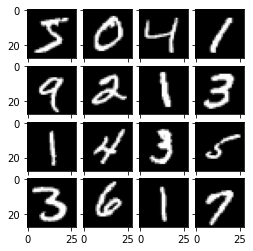

In [3]:
im_list = []
n_samples_to_show = 16
c = 0
for i in range(n_samples_to_show):
  im_list.append(x_train[i])
# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(4., 4.))
# Ref: https://matplotlib.org/3.1.1/gallery/axes_grid1/simple_axesgrid.html
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
# Show image grid
for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im[:,:,0], 'gray')
plt.show()

In [4]:
batch_size = 32
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

In [5]:
# Model building
NUM_CLASSES = 10
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')]
    )

In [6]:
# Defining loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
accuracy_metric = tf.keras.metrics.Accuracy()

# Calculate loss
def loss_fn(gt_label, pred):
  # training argument define the beehaviour of layers with respect
  # to whether we are training the model or not. It is important for layers
  # such as BatchNorm and Dropout.
  return loss_object(y_true=gt_label, y_pred=pred)

def accuracy_fn(gt_label, output):
  # calculate the accuracy by turning output into labels with argmax
  pred = tf.argmax(output, axis=1, output_type=tf.int32)
  return accuracy_metric(pred, gt_label)


In [7]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [8]:
NUM_EPOCHS = 5
EPOCH_PER_DISPLAY = 1
total_loss = []
for epoch in range(NUM_EPOCHS):

  running_loss = []
  running_accuracy = []

  # Training
  for input, target in train_dataset:

    # Calculate and track graduents
    with tf.GradientTape() as tape:

      # Calculate model output and loss
      output = model(input, training=True)
      loss_ = loss_fn(target, output)
      accuracy_ = accuracy_fn(target, output)
      
      # Tape gradients
      grads = tape.gradient(loss_, model.trainable_variables)
      
    # Track batch loss and accuracy
    running_loss.append(loss_)
    running_accuracy.append(accuracy_)

    # Optimize model based on the gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  # Epoch calculations
  epoch_loss = np.mean(running_loss)
  epoch_accuracy = np.mean(running_accuracy)
  if (epoch + 1) % EPOCH_PER_DISPLAY == 0:
    print("Epoch {}: Loss: {:.4f} Accuracy: {:.2f}%".format(epoch+1, epoch_loss, epoch_accuracy * 100))


Epoch 1: Loss: 0.1450 Accuracy: 92.06%
Epoch 2: Loss: 0.0816 Accuracy: 96.28%
Epoch 3: Loss: 0.0834 Accuracy: 96.90%
Epoch 4: Loss: 0.0825 Accuracy: 97.21%
Epoch 5: Loss: 0.0784 Accuracy: 97.41%


In [9]:
# Calculate the accurcy on the test set
running_accuracy = []
for (input, gt_label) in test_dataset:
  output = model(input, training=False)
  accuracy_ = accuracy_fn(gt_label, output)
  running_accuracy.append(accuracy_)

print("Test accuracy: {:.3%}".format(np.mean(running_accuracy)))


Test accuracy: 97.509%
